In [1]:
# 기본 데이터 처리 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# 시계열 분석을 위한 라이브러리
from statsmodels.tsa.seasonal import seasonal_decompose

# Scikit-learn 라이브러리 (데이터 전처리 및 평가)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Keras/TensorFlow 라이브러리 (모델링)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 기본 설정
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# 데이터셋 불러오기
try:
    df = pd.read_csv('avocado.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: 'avocado.csv' not found. Please make sure the file is in the correct directory.")

# 불필요한 컬럼 제거
df = df.drop('Unnamed: 0', axis=1)

# 'Date' 컬럼을 datetime 형식으로 변환하고 인덱스로 설정
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 날짜순으로 데이터 정렬
df.sort_index(inplace=True)

print("\nData after cleaning and sorting:")
df.head()

Data loaded successfully!

Data after cleaning and sorting:


,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


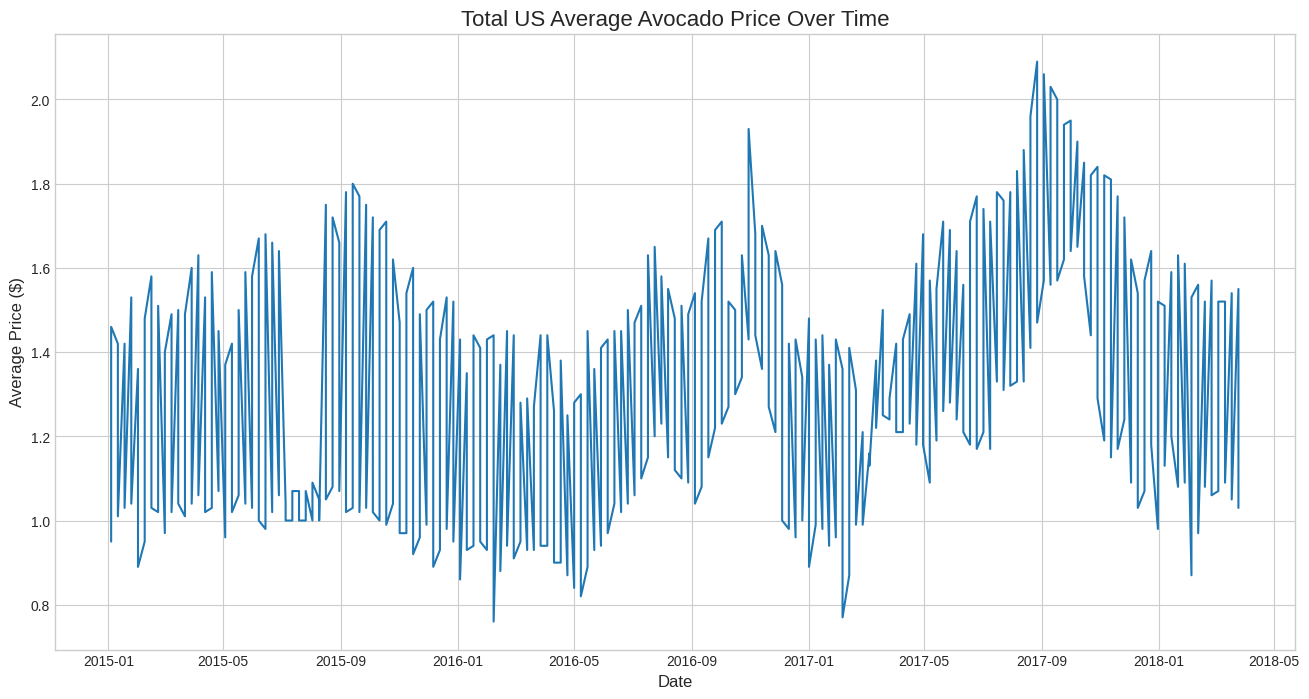

In [3]:
# 미국 전체(TotalUS)의 평균 가격 추세 시각화
plt.figure(figsize=(16, 8))
plt.plot(df[df['region']=='TotalUS']['AveragePrice'])
plt.title('Total US Average Avocado Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.show()

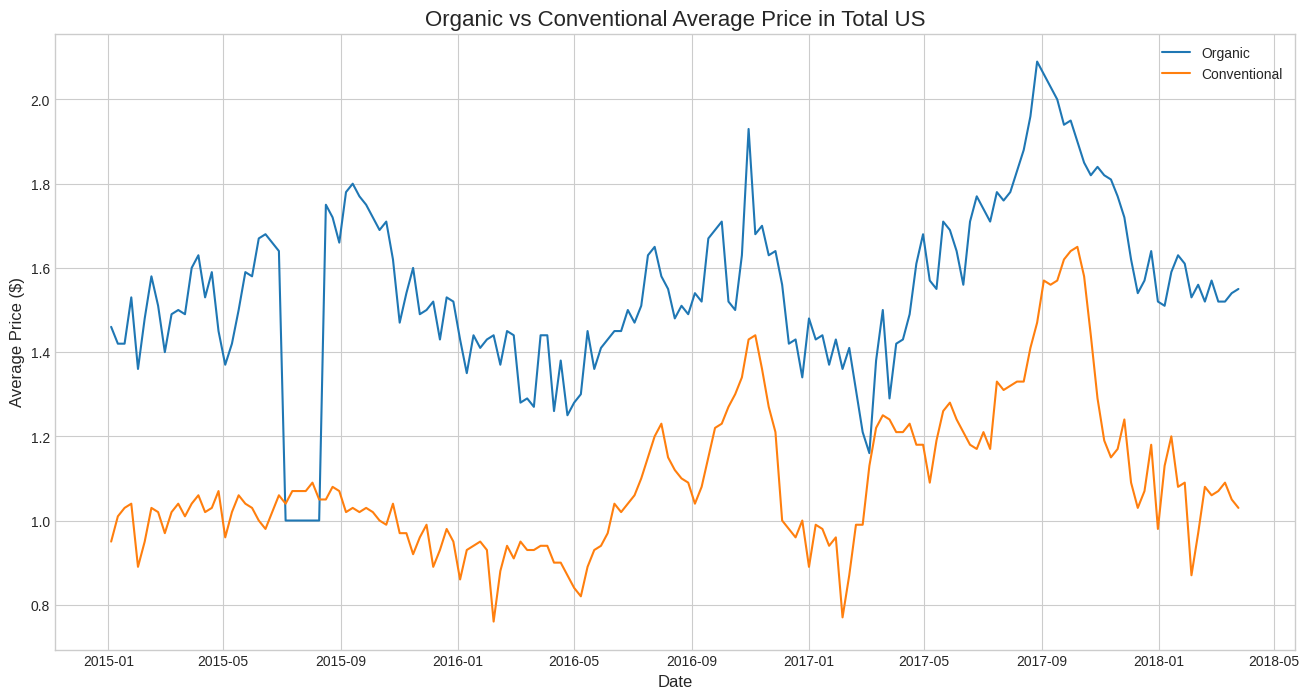

In [4]:
# 유기농과 일반 아보카도의 가격 추세 비교
plt.figure(figsize=(16, 8))

# 미국 전체, 유기농
df_organic = df[(df['region']=='TotalUS') & (df['type']=='organic')]
plt.plot(df_organic.index, df_organic['AveragePrice'], label='Organic')

# 미국 전체, 일반
df_conv = df[(df['region']=='TotalUS') & (df['type']=='conventional')]
plt.plot(df_conv.index, df_conv['AveragePrice'], label='Conventional')

plt.title('Organic vs Conventional Average Price in Total US', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.legend()
plt.show()

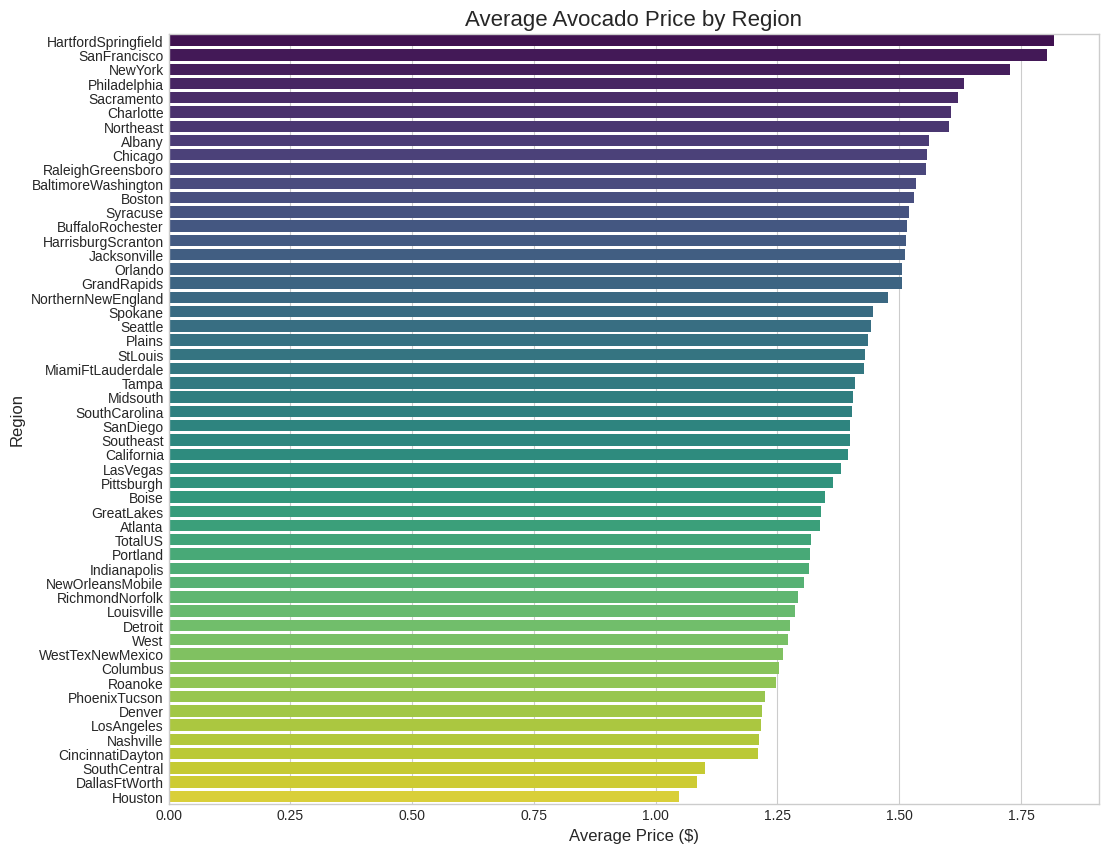

In [5]:
# 지역별 평균 가격 계산 및 시각화
region_price = df.groupby('region')['AveragePrice'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x=region_price.values, y=region_price.index, palette='viridis')
plt.title('Average Avocado Price by Region', fontsize=16)
plt.xlabel('Average Price ($)', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.show()

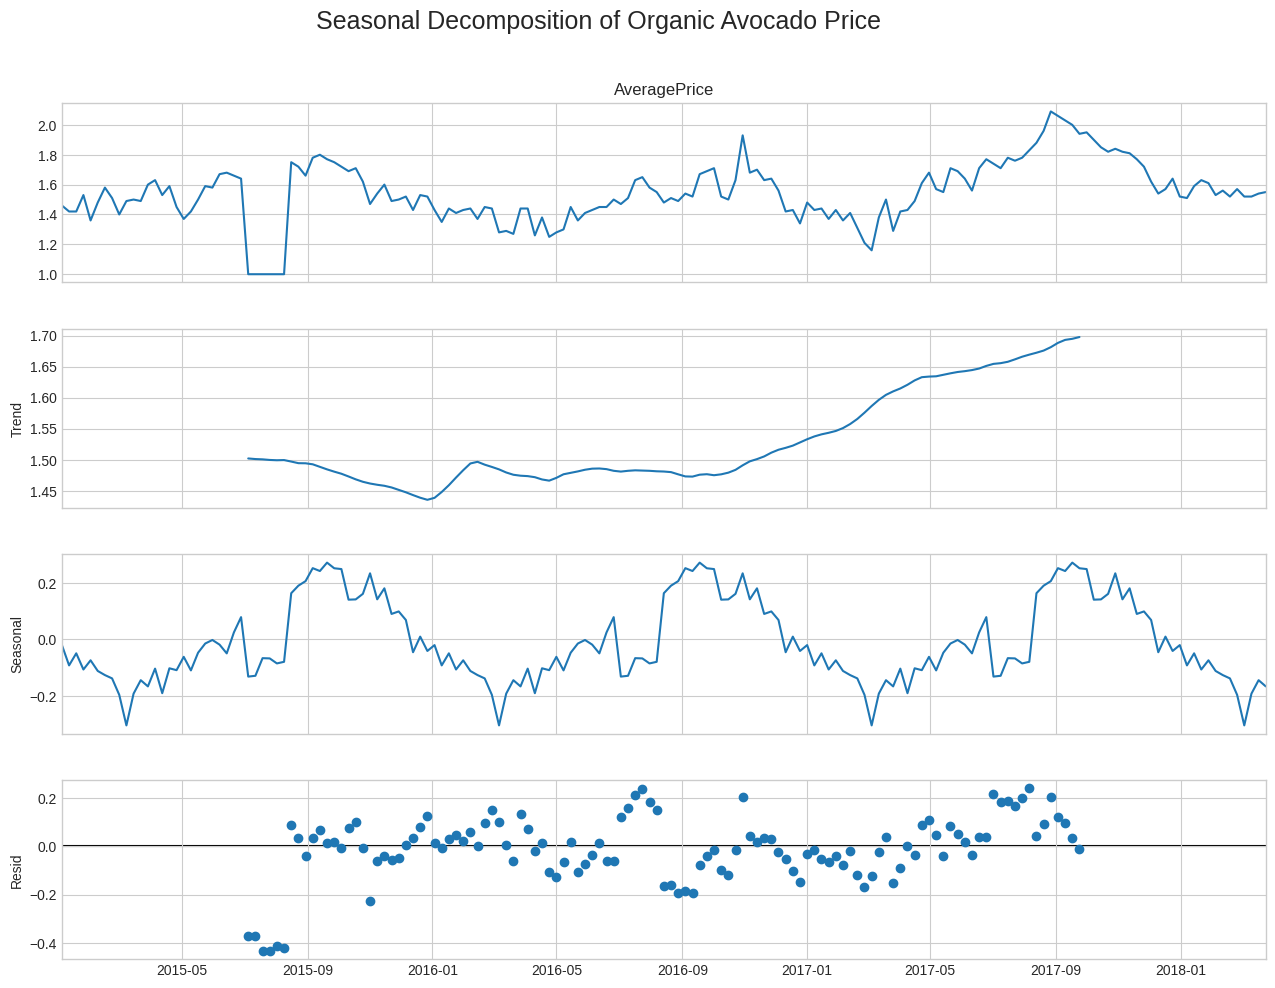

In [6]:
# 시계열 분해를 위해 데이터 준비
ts_data = df_organic['AveragePrice'].copy()

# seasonal_decompose를 사용하여 시계열 분해
decomposition = seasonal_decompose(ts_data, model='additive', period=52) # 1년 주기를 52주로 가정

# 분해 결과 시각화
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Seasonal Decomposition of Organic Avocado Price', fontsize=18, y=1.02)
plt.show()

In [7]:
# 분석할 시계열 데이터 선택
price_series = df_organic['AveragePrice'].values.reshape(-1, 1)

# 데이터 스케일링 (0과 1 사이로 정규화)
# 신경망 모델은 입력 데이터의 스케일에 민감하므로 정규화는 중요합니다.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler.fit_transform(price_series)

In [8]:
# 시계열 데이터를 지도 학습 데이터(시퀀스)로 변환하는 함수
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# 시퀀스 생성 (과거 10주 데이터로 다음 주 가격 예측)
n_steps = 10
X, y = split_sequence(scaled_price, n_steps)

print("Shape of sequence data:")
print("X shape:", X.shape)
print("y shape:", y.shape)

Shape of sequence data:
X shape: (159, 10, 1)
y shape: (159, 1)


In [9]:
# 학습/테스트 데이터 분할 (마지막 20%를 테스트 데이터로 사용)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM 입력 형식에 맞게 데이터 형태 변경: [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print("Shape of training data for LSTM:", X_train.shape)
print("Shape of test data for LSTM:", X_test.shape)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# 모델 컴파일 (손실 함수: MSE, 옵티마이저: Adam)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Shape of training data for LSTM: (127, 10, 1)
Shape of test data for LSTM: (32, 10, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 모델 학습
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1, batch_size=32)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 0.2444 - val_loss: 0.2914
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1988 - val_loss: 0.2453
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1723 - val_loss: 0.2021
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1372 - val_loss: 0.1619
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1009 - val_loss: 0.1233
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0728 - val_loss: 0.0837
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0466 - val_loss: 0.0469
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0262 - val_loss: 0.0208
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0263 - val_loss: 0.0154
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0339 - val_loss: 0.0149
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0288 - val_loss: 0.0202
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0241 - val_l

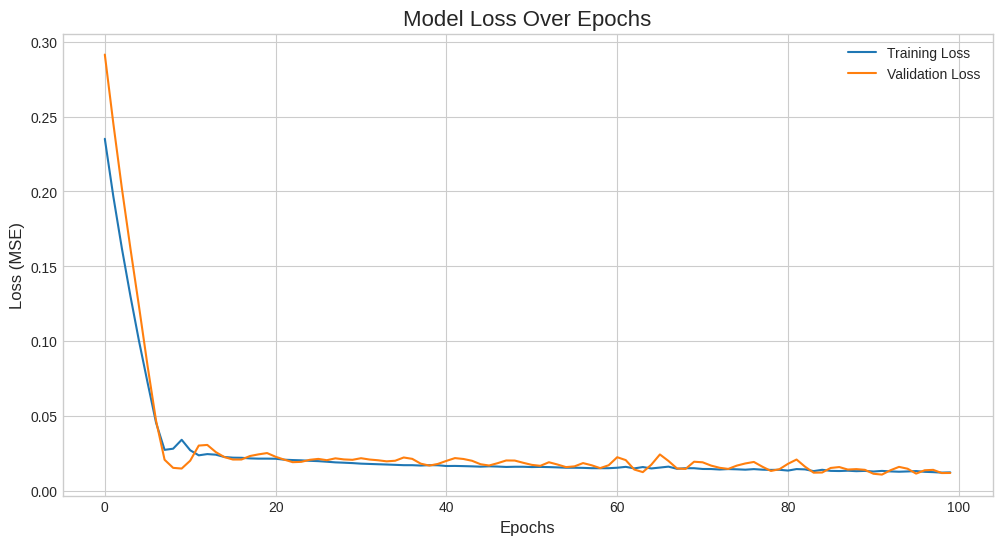

In [11]:
# 학습 과정의 손실(Loss) 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


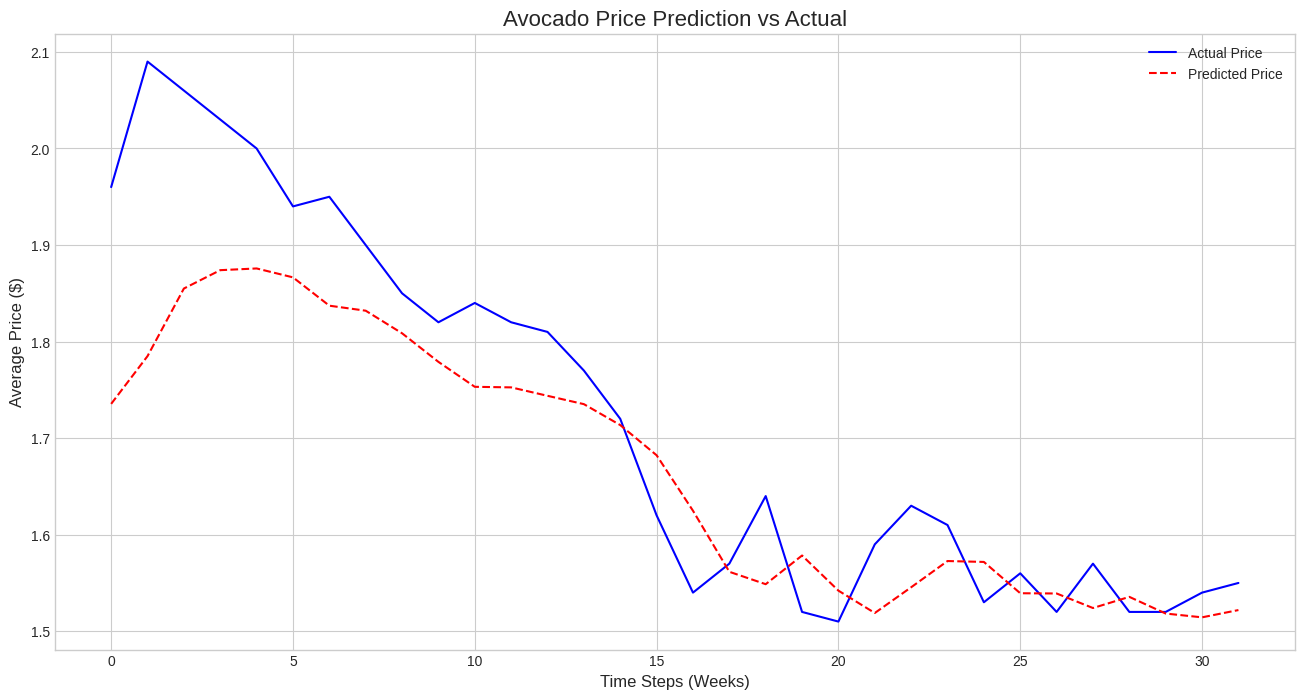

In [12]:
# 테스트 데이터에 대한 예측
y_pred_scaled = model.predict(X_test)

# 스케일링된 예측값을 원래 가격으로 복원
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)

# 실제 값과 예측 값 시각화
plt.figure(figsize=(16, 8))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='red', linestyle='--')
plt.title('Avocado Price Prediction vs Actual', fontsize=16)
plt.xlabel('Time Steps (Weeks)', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.legend()
plt.show()

In [13]:
# 정량적 성능 평가
mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

print("--- Model Performance Evaluation ---\n")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

--- Model Performance Evaluation ---

Mean Absolute Error (MAE): 0.0732
Mean Squared Error (MSE): 0.0098
Root Mean Squared Error (RMSE): 0.0989
R-squared (R2 Score): 0.7250
